# Trash Classification

This notebook is detecated to find out if a given trash (via its image) is recyclable or not. We'll try to adapt the previous model to the torch library


## Importing modules

In [58]:
import pandas as pd
import numpy as np
import os

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import confusion_matrix

## Loading Data

### Defining a function to retrieve data (downloaded from Kaggle)

In [40]:
class TrashDataset(Dataset):
    def __init__(self, dir_path, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        class_map = {'R': 0, 'O': 1}

        for label_folder in ['R', 'O']:
            folder_path = os.path.join(dir_path, label_folder)
            for file in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, file))
                self.labels.append(class_map[label_folder])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [41]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

### CNN Model (equivalent to Sequential)

In [42]:
class TrashCNN(nn.Module):
    def __init__(self):
        super(TrashCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)  # Pour binaire : 1 neurone

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


### Model Training

#### Preparing Data

In [43]:
TRAIN_PATH = "data/TRAIN"
TEST_PATH = "data/TEST"

In [48]:
dataset = TrashDataset(TRAIN_PATH, transform=transform)
train_len = int(0.8*len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

In [49]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

#### Initializing the model

In [52]:
model = TrashCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Training

In [62]:
for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        labels = labels.float().unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculating accuracy
        predictions = (outputs >= 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    accuracy = correct/total
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {accuracy*100:.2f}%")

Epoch 1 - Loss: 0.0981 - Accuracy: 96.40%
Epoch 2 - Loss: 0.0792 - Accuracy: 96.90%
Epoch 3 - Loss: 0.0824 - Accuracy: 97.12%
Epoch 4 - Loss: 0.0795 - Accuracy: 97.00%
Epoch 5 - Loss: 0.0719 - Accuracy: 97.27%
Epoch 6 - Loss: 0.0753 - Accuracy: 97.43%
Epoch 7 - Loss: 0.0599 - Accuracy: 97.76%
Epoch 8 - Loss: 0.0706 - Accuracy: 97.53%
Epoch 9 - Loss: 0.0527 - Accuracy: 98.01%
Epoch 10 - Loss: 0.0541 - Accuracy: 97.95%
Epoch 11 - Loss: 0.0577 - Accuracy: 97.96%
Epoch 12 - Loss: 0.0501 - Accuracy: 98.19%
Epoch 13 - Loss: 0.0553 - Accuracy: 98.07%
Epoch 14 - Loss: 0.0499 - Accuracy: 98.11%
Epoch 15 - Loss: 0.0492 - Accuracy: 98.42%
Epoch 16 - Loss: 0.0490 - Accuracy: 98.30%
Epoch 17 - Loss: 0.0455 - Accuracy: 98.57%
Epoch 18 - Loss: 0.0433 - Accuracy: 98.45%
Epoch 19 - Loss: 0.0466 - Accuracy: 98.35%
Epoch 20 - Loss: 0.0478 - Accuracy: 98.28%


#### Results
Epoch 20 - Loss: 0.0478 - Accuracy: 98.28%
Training time: 15m 51s

### Testing the Model

#### Defining an evaluate function

In [55]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            predictions = (outputs >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

#### Loading Test Data

In [56]:
test_dataset = TrashDataset(TEST_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Evaluation

In [63]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"[TEST] Loss: {test_loss:.4f} - Accuracy: {test_accuracy*100:.2f}%")

[TEST] Loss: 0.9426 - Accuracy: 90.69%


### Confusion Matrix

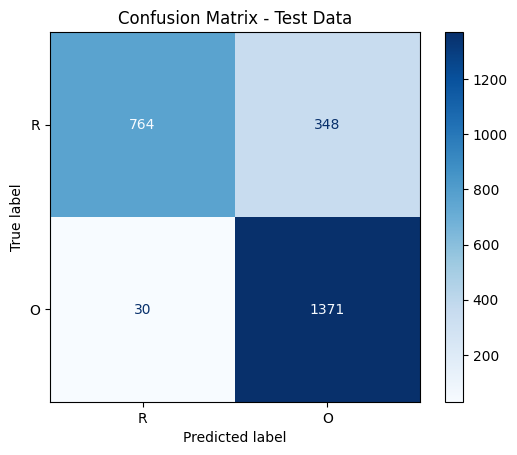

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.float().unsqueeze(1)
        outputs = model(inputs)
        preds = (outputs >= 0.5).float()

        all_preds.extend(preds.squeeze().tolist())
        all_labels.extend(labels.squeeze().tolist())

# Calcul de la matrice
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['R', 'O'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Data")
plt.show()


### Misclassified Images

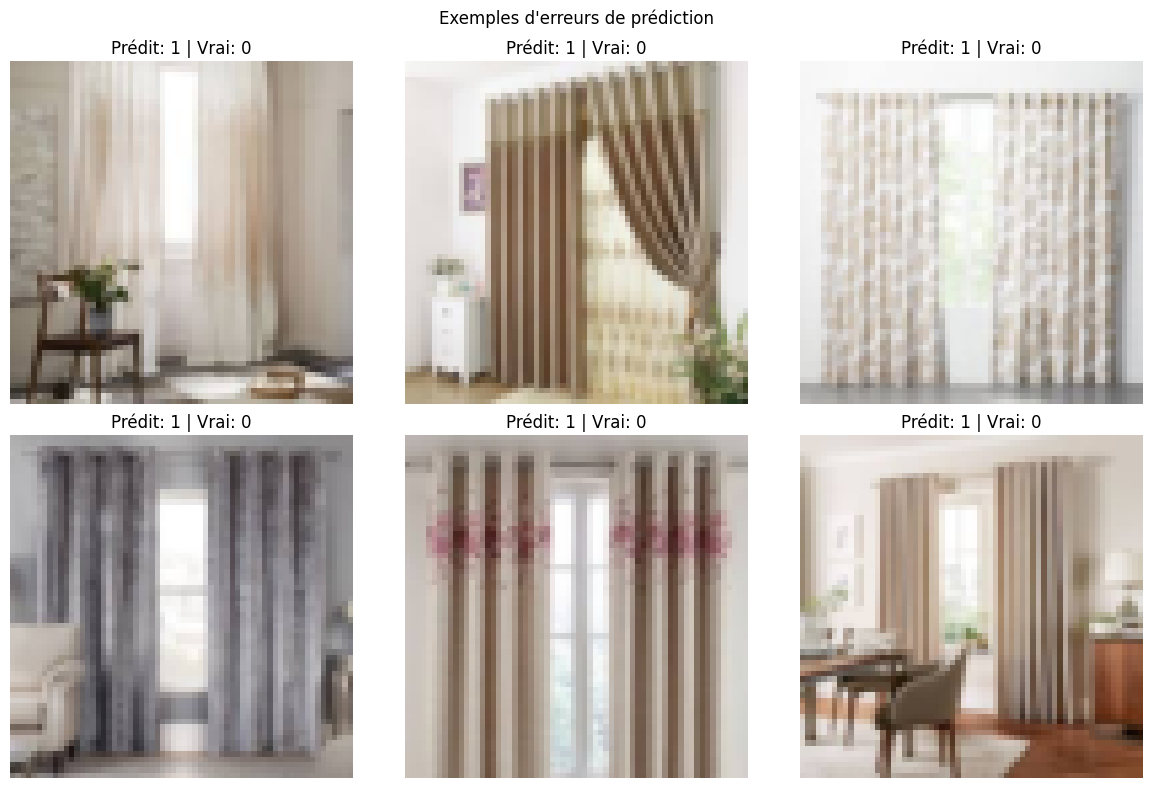

In [61]:
misclassified = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.float().unsqueeze(1)
        outputs = model(inputs)
        preds = (outputs >= 0.5).float()

        for img, pred, true in zip(inputs, preds, labels):
            if pred != true:
                misclassified.append((img, int(pred.item()), int(true.item())))

# Printing a maximum of 6 images
plt.figure(figsize=(12, 8))
for i, (img, pred, true) in enumerate(misclassified[:6]):
    plt.subplot(2, 3, i + 1)
    img_np = img.permute(1, 2, 0).numpy()
    plt.imshow(img_np)
    plt.title(f"Prédit: {pred} | Vrai: {true}")
    plt.axis('off')

plt.suptitle("Exemples d'erreurs de prédiction")
plt.tight_layout()
plt.show()
